### Importing

In [1]:
import cv2
from matplotlib import pyplot as plt
import math
import mido
import numpy as np
import os
import random

In [2]:
print("\nLoading Keras...")
import tensorflow.keras
print(f"Keras Version: {tensorflow.keras.__version__}")


Loading Keras...
Keras Version: 2.4.0


In [3]:
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Dense, Activation, Dropout, Flatten, Reshape, TimeDistributed
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.optimizers import RMSprop

### Setting variables

In [4]:
#Generating random songs settings
GENERATE_ONLY = False
NUM_RAND_SONGS = 10

WRITE_HISTORY = True

#Network parameters
BATCH_SIZE = 350
CONTINUE_TRAIN = False
DROPOUT_RATE = 0.1
LEARNIN_RATE = 0.001
MAX_LENGTH = 4
NUM_EPOCHS = 1
NUM_OFFSETS = 4
PARAM_SIZE = 120
#Batchnorm momentoum
BN_M = 0.9

#Fix the random seed
np.random.seed(0)
random.seed(0)

### Utilities to save the model statistics and generated song

In [5]:
def save_config():
    """
    Save training configs.
    """
    with open('results/config.txt', 'w') as fout:
        fout.write(f'Learning rate: {LEARNIN_RATE} \n')
        fout.write(f'Batchnorm momentoum: {BN_M}f\n')
        fout.write(f'Batch size: {BATCH_SIZE} \n')
        fout.write(f'Offsets: {NUM_OFFSETS} \n')
        fout.write(f'Dropout rate: {DROPOUT_RATE} \n')
        fout.write(f'Number of songs: {num_songs} \n')
        fout.write(f'optimizer: {type(model.optimizer).__name__} \n')

In [6]:

def plotScores(scores, fname, on_top=True):
    """
    Plot model loss.
    """
    plt.clf()
    ax = plt.gca()
    ax.yaxis.tick_right()
    ax.yaxis.set_ticks_position('both')
    ax.yaxis.grid(True)
    plt.plot(scores)
    plt.ylim([0.0, 0.009])
    plt.xlabel('Epoch')
    loc = ('upper right' if on_top else 'lower right')
    plt.draw()
    plt.savefig(fname)

In [7]:
def make_rand_songs(write_dir, rand_vecs):
    for i in range(rand_vecs.shape[0]):
        x_rand = rand_vecs[i:i+1]
        y_song = func(x_rand)[0]
        midi.samples_to_midi(y_song[0], write_dir + 'rand' + str(i) + '.mid', 96, 96)

def make_rand_songs_normalized(write_dir, rand_vecs):
    x_enc = np.squeeze(enc.predict(y_orig))
    
    x_mean = np.mean(x_enc, axis=0)
    x_stds = np.std(x_enc, axis=0)
    x_cov = np.cov((x_enc - x_mean).T)
    u, s, v = np.linalg.svd(x_cov)
    e = np.sqrt(s)

    print("Means: ", x_mean[:6])
    print("Evals: ", e[:6])
    
    np.save(write_dir + 'means.npy', x_mean)
    np.save(write_dir + 'stds.npy', x_stds)
    np.save(write_dir + 'evals.npy', e)
    np.save(write_dir + 'evecs.npy', v)

    x_vecs = x_mean + np.dot(rand_vecs * e, v)
    make_rand_songs(write_dir, x_vecs)
    
    title = ''
    if '/' in write_dir:
        title = 'Epoch: ' + write_dir.split('/')[-2][1:]
    
    plt.clf()
    e[::-1].sort()
    plt.title(title)
    plt.bar(np.arange(e.shape[0]), e, align='center')
    plt.draw()
    plt.savefig(write_dir + 'evals.png')
    
    plt.clf()
    plt.title(title)
    plt.bar(np.arange(e.shape[0]), x_mean, align='center')
    plt.draw()
    plt.savefig(write_dir + 'means.png')
    
    plt.clf()
    plt.title(title)
    plt.bar(np.arange(e.shape[0]), x_stds, align='center')
    plt.draw()
    plt.savefig(write_dir + 'stds.png')

In [8]:
#Util to use img .png
def sample_to_pic(fname, sample, thresh=None):
    if thresh is not None:
        inverted = np.where(sample > thresh, 0, 1)
    else:
        inverted = 1.0 - sample
    cv2.imwrite(fname, inverted * 255)

def samples_to_pics(dir, samples, thresh=None):
    if not os.path.exists(dir): 
        os.makedirs(dir)
    for i in range(samples.shape[0]):
        sample_to_pic(dir + '/s' + str(i) + '.png', samples[i], thresh)

In [9]:
def samples_to_midi(samples, fname, num_notes, SPM, thresh=0.5):
    """
    Turn samples into midi. Reagroup samples into a measure.
    :param samples: List of samples that will be jointed (dtype=np.uint8)
    :param fname: Midi file name that will be used
    :param num_notes: Number of notes wanted for the sample 
    :param SPM: Samples per measured int the mid file 
    :param thresh: the higher the treshold the less notes will come out of the song
    :return:
    """
    #Creates mid object and adding track to it
    mid = mido.MidiFile()
    track = mido.MidiTrack()
    mid.tracks.append(track)

    TPM = 4 * mid.ticks_per_beat #Get ticks per measure
    ticks_per_sample = TPM / SPM
    
    #Its possible to add types of instruments but i wont do it in this version fell free to add it
    #en.wikipedia.org/wiki/General_MIDI#Program_change_events

    abs_time = 0
    last_time = 0

    for sample in samples:
        for y in range(sample.shape[0]):
            abs_time += ticks_per_sample
            
            for x in range(sample.shape[1]):
                ####### It needs an upgrade #######
                #Transform the notes into the wanted scale
                note = x + (128 - num_notes)/2

                ####### It needs an upgrade #######
                # velocity = int(sample[y,x]*127)
                if sample[y,x] >= thresh and (y == 0 or sample[y - 1, x] < thresh):
                    delta_time = abs_time - last_time
                    track.append(mido.Message('note_on', note=int(note), velocity=127, time=int(delta_time)))
                    last_time = abs_time
                
                if sample[y,x] >= thresh and (y == sample.shape[0] - 1 or sample[y + 1, x] < thresh):
                    delta_time = abs_time - last_time
                    track.append(mido.Message('note_off', note=int(note), velocity=127, time=int(delta_time)))
                    last_time = abs_time
                    
    return mid.save(fname)

### Model

In [10]:
# Create folders to save models into
if not os.path.exists('results'):
    os.makedirs('results')
if WRITE_HISTORY and not os.path.exists('results/history'):
    os.makedirs('results/history')

#Checking if there is data and loading it 
print("\nLoading Data...")
try:
    y_samples = np.load("samples424.npy")
    print("samples loded")
    y_lengths = np.load("lengths424.npy")
    print("lengths loded")
except:
    raise FileNotFoundError("No data found, try to check if you have a input dataset, and run four2fourTimeSignature.ipynb again!")


Loading Data...
samples loded
lengths loded


In [11]:
#Sets the number of samples, already printed in load_songs.py
num_samples = y_samples.shape[0]
num_songs = y_lengths.shape[0]

print(f"Loaded {num_samples} samples from {num_songs} songs.\n")
assert(np.sum(y_lengths) == num_samples)

x_shape = (num_songs * NUM_OFFSETS, 1) 
x_orig = np.expand_dims(np.arange(x_shape[0]), axis=-1) 

# y_shape = (num of songs, max num of window, num of pithc per window, num of notes)
y_shape = (num_songs * NUM_OFFSETS, MAX_LENGTH) + y_samples.shape[1:] #This case (n, 4, 16, 128)
y_orig = np.zeros(y_shape, dtype=y_samples.dtype) #Prepare dataset array

Loaded 222824 samples from 1002 songs.



In [12]:
## fill in measure of songs into input windows for network
# Song start index
SSix = 0
# Song end index
SEix = 0

for song_ix in range(50):
    for offset in range(NUM_OFFSETS):
        ix = song_ix * NUM_OFFSETS + offset # calculate the index of the song with its offset
        SEix = SSix + y_lengths[song_ix] 
        
        for window_ix in range(MAX_LENGTH):
            size = (window_ix + offset) % y_lengths[song_ix]  # chosen measure of song to be placed in window (modulo song length)
            y_orig[ix,window_ix] = y_samples[SSix + size] # move measure into window
    SSix = SEix

x_train = np.copy(x_orig)
y_train = np.copy(y_orig)

In [13]:
# copy some song from the samples and write it to midi again
test_ix = 0
y_test_song = np.copy(y_train[test_ix: test_ix + 1])
x_test_song = np.copy(x_train[test_ix: test_ix + 1])
samples_to_midi(y_test_song[0], 'gt.mid', 128, 16)

In [14]:
rand_vecs = np.random.normal(0.0, 1.0, (NUM_RAND_SONGS, PARAM_SIZE))
np.save('rand.npy', rand_vecs)

In [15]:
#Create Model
if CONTINUE_TRAIN or GENERATE_ONLY:
    print("\nLoading Model...")
    model = load_model('results/history/model.h5')
else:
    print("\nBuilding Model...")
    model = Sequential()
    model.add(Input(shape=y_shape[1:]))
    model.add(Reshape((y_shape[1], -1)))
    model.add(TimeDistributed(Dense(2000, activation='relu')))
    model.add(TimeDistributed(Dense(200, activation='relu')))
    model.add(Flatten())
    model.add(Dense(1600, activation='relu'))
    model.add(Dense(PARAM_SIZE))
    model.add(BatchNormalization(momentum=BN_M, name='encoder'))


    model.add(Dense(1600, name='decoder'))
    model.add(BatchNormalization(momentum=BN_M))
    model.add(Activation('relu'))
    if DROPOUT_RATE > 0:
        model.add(Dropout(DROPOUT_RATE))
    model.add(Dense(MAX_LENGTH * 200))
    model.add(Reshape((MAX_LENGTH, 200)))
    model.add(TimeDistributed(BatchNormalization(momentum=BN_M)))
    model.add(Activation('relu'))
    if DROPOUT_RATE > 0:
        model.add(Dropout(DROPOUT_RATE))
    model.add(TimeDistributed(Dense(2000)))
    model.add(TimeDistributed(BatchNormalization(momentum=BN_M)))
    model.add(Activation('relu'))
    if DROPOUT_RATE > 0:
        model.add(Dropout(DROPOUT_RATE))
    model.add(TimeDistributed(Dense(y_shape[2] * y_shape[3], activation='sigmoid')))
    model.add(Reshape((y_shape[1], y_shape[2], y_shape[3])))
    model.compile(optimizer=RMSprop(lr=LEARNIN_RATE), loss='binary_crossentropy')
    print("Builded")
    


Building Model...
Builded


In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 4, 2048)           0         
_________________________________________________________________
time_distributed (TimeDistri (None, 4, 2000)           4098000   
_________________________________________________________________
time_distributed_1 (TimeDist (None, 4, 200)            400200    
_________________________________________________________________
flatten (Flatten)            (None, 800)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1600)              1281600   
_________________________________________________________________
dense_3 (Dense)              (None, 120)               192120    
_________________________________________________________________
encoder (BatchNormalization) (None, 120)               4

In [17]:
# print("Compiling SubModels...")
# func = K.function([model.get_layer('encoder').input, K.learning_phase()],[model.layers[-1].output])
# enc = Model(inputs=model.input, outputs=model.get_layer('decoder').output)


Training...
12/12 [==============================] - 11s 398ms/step - loss: 0.2374

Train Loss: 0.10238069295883179

Saved

Done


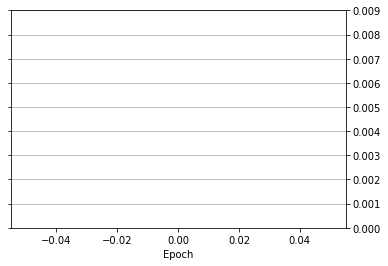

In [18]:
if GENERATE_ONLY:
    print("\nGenerating Songs...")
    make_rand_songs_normalized('', rand_vecs)
    for i in range(20):
        x_test_song = x_train[i:i+1]
        y_song = model.predict(x_test_song, batch_size=BATCH_SIZE)[0]
        midi.samples_to_midi(y_song, 'gt' + str(i) + '.mid', 96, 96)
    exit(0)
          
print("\nTraining...")
save_config()
train_loss = []
ofs = 0

for iter in range(NUM_EPOCHS):
    cur_ix = 0
    for i in range(num_songs):
        end_ix = cur_ix + y_lengths[i]
        for j in range(MAX_LENGTH):
            k = (j + ofs) % (end_ix - cur_ix)
            y_train[i,j] = y_samples[cur_ix + k]
        cur_ix = end_ix
    assert(end_ix == num_samples)
    ofs += 1

    history = model.fit(y_train, y_train, batch_size=BATCH_SIZE, epochs=1)

    loss = history.history["loss"][-1]
    train_loss.append(loss)
    print("\nTrain Loss: " + str(train_loss[-1]))
    
    if WRITE_HISTORY:
        plotScores(train_loss, 'results/history/Scores.png', True)
    else:
        plotScores(train_loss, 'Scores.png', True)
    
    i = iter + 1
    if i in [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 120, 140, 160, 180, 200, 250, 300, 350, 400, 450] or (i % 100 == 0):
        write_dir = ''
        if WRITE_HISTORY:
            #Create folder to save models into
            write_dir = 'results/history/e' + str(i)
            if not os.path.exists(write_dir):
                os.makedirs(write_dir)
            write_dir += '/'
            model.save('results/history/model.h5')
        else:
            model.save('model.h5')
        print("\nSaved")

        y_song = model.predict(y_test_song, batch_size=BATCH_SIZE)[0]
        samples_to_pics(write_dir + 'test', y_song)
        samples_to_midi(y_song, write_dir + 'test.mid', 96, 96)

        # make_rand_songs_normalized(write_dir, rand_vecs)


print("\nDone")
